<a href="https://colab.research.google.com/github/zlatatikhomirova/emotion_recognition/blob/main/EEG_with_comments_3__in_progress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Справочная информация перед задачей**

Волна **P300 (P3)** является компонентой связанных с событиями вызванных по-
тенциалов. Она возникает в ходе принятия решения, а именно в процессе оценки и категоризации стимула и наблюдается на ЭЭГ приблизительно через **250-500 миллисекунд после его возникновения.**

Из-за присутствия в сигнале ЭЭГ множества компонент, P300 сложно зафиксировать при одиночной демонстрации стимула, поэтому стимул повторяют несколько раз с некоторым временным интервалом. Усреднив достаточное количество графиков
ЭЭГ при наличии стимула и без него, можно детектировать P300.
На графике из статьи [1] вы можете наблюдать различие усреднённого сигнала
ЭЭГ после применения стимула и без него.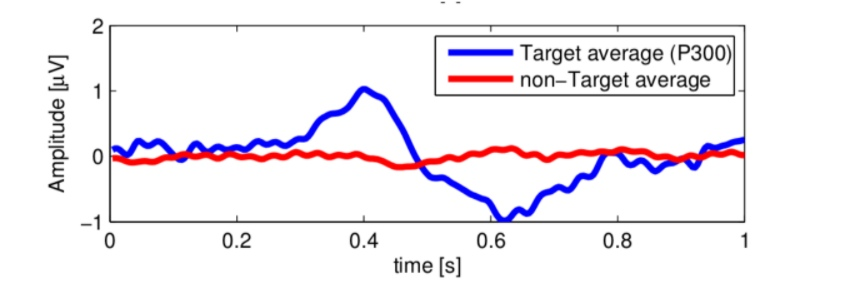

# <center> Задача






**Дано:**

16-канальная запись электроэнцефалограммы для 5 испытуемых. 

**О эксперименте:**

В ходе эксперимента испытуемый смотрел на дисплей с 36 объектами расположенными в виде матрицы 6x6. Изначально подсветка всех объектов была выключена.
Включение подсветки символа, за которым наблюдал испытуемый, вызывало возникновение волны P300 на ЭЭГ.

**Датасет:**

(https://drive.google.com/le/d/1FBarUXlM-2Dml1-K8YOdUBjuf_G3mexC/view?usp=sharing).

**Организация файлов:**

**dataset/n/folder/*.csv**

***n*** - номер испытуемого (от 0 до 5);

***folder*** - target, non-target и test, относящиеся к одному испытуемому (лежат внутри одной директории под номером n (номером испытуемого)).

В директории **target** - отрезки сигнала, где есть P300.

В директории **non-target** - отрезки сигнала, где нет P300. 

В директории **test** - тестовые данные.

В каждой **folder** есть несколько ***.csv**, где хранятся отрезки отфильтрованного сигнала (каждый длительностью 1 с, частота оцифровки - 512 Гц). 

Каждый отрезок сигнала находится в отдельном ***.csv** файле, началу отрезка соответствует момент включения подсветки группы объектов. 

Столбцы в файле соответствуют отдельным каналам ЭЭГ: **Fp1, Fp2, F3, AFz, F4, T7, Cz, T8, P7, P3, Pz, P4, P8, O1, Oz, O2.**

Тестовые файлы имеют сквозную нумерацию. Ответ следует предоставить в виде строки из разделённым пробелом названий тестовых файлов (без расширения) относящихся к **target**.

Первым делом импортируем библиотеки.


In [ ]:
import numpy as np                    #  Для вычислений и загрузки файлов
import matplotlib.pyplot as plt       #  Для построения графиков
import matplotlib.ticker as ticker    #  Для того, чтобы устанавливать деления на осях на графике
from itertools import zip_longest     #  Для объединения нескольких списков разной/одинаковой длины в список кортежей
from sklearn.svm import SVC           #  Метод опорных векторов
import sklearn

import os                             #  Для работы с файловой системой и ОС
import pathlib

Затем напишем функции для обработки сигналов и детекции P300.

1) функция усреднения по каналам AFz, Cz, Pz, Oz;

Складываем значения четырех сагиттальных каналов (у которых есть z) между собой, делим на количество каналов. Может быть Oz не нужно было считать, но чем больше каналов, тем выше вероятность того, что мы обнаружим волну P300.
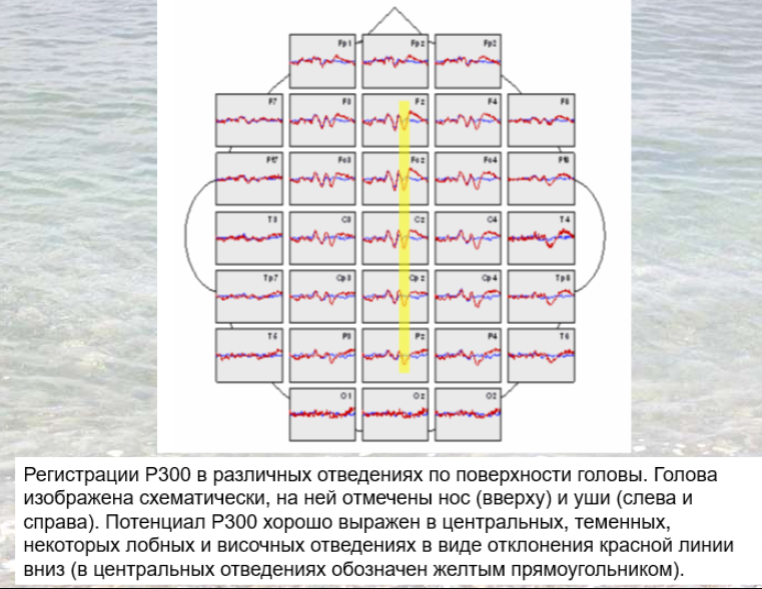

2) нормализация данных.

Первая функция.
Каждый канал образует список. Все каналы являются элементами списка, образующего отрезок сигнала.
Каналы AFz, Cz, Pz, Oz имеют индексы 3, 6, 10 и 14 соответственно. С помощью функции zip_longest объединяем эти 4 списка в список кортежей. Затем последовательно складываем элементы этих списков между собой. Чтобы получить среднее значение для каждого элемента, последовательно делим каждый элемент нового множества на количество списков, участвовавших в образовании этого множества (их изначально 4). Преобразуем полученный список в np.ndarray.

В отдельный np.ndarray запишем промежуток времени длиной 1 с, разделенный на мс.

Вторую функцию сделаем частью первой. Вычисляем амплитуду, последовательно делим значения среза списка усреднённой ЭЭГ на промежутке 250-500 мс на неё.

Возвращаем преобразованный срез списка усреднённой ЭЭГ.

In [ ]:
def moving_average(a, n=4):
  b = []
  for i in range(0, len(a), n):
    b.append(np.mean)
  return b

In [ ]:
def hh1(target11):
  target5 = [x+y+z+q+a+b+c for x, y, z, q, a, b, c in zip_longest(target11[2], target11[3], target11[4], target11[6], target11[9], target11[10], target11[11], fillvalue=0)]
  target = np.array([x/7 for x in target5])
  sec = np.arange(0, len(target))/512
  amp = (max(target) - min(target))/2
  return target[np.where((sec>=0.25)&(sec<=0.6))] / amp

Загрузка данных с google drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Загрузка данных.

Примечание:

В цикле с помощью функции tolist() мы преобразовываем np.ndarray в обычный список для облегчения дальнейшей работы с кодом.

In [ ]:
bpath = "/content/drive/MyDrive/EEG_02.02"

def read_train(number):
    non_target_signals = []
    target_signals = []
    test_signals = []

    target_path = pathlib.Path(f'{bpath}/{number}/target')
    non_target_path = pathlib.Path(f'{bpath}/{number}/non-target')
    test_path = pathlib.Path(f'{bpath}/{number}/test')
    
    if not target_path.exists() or not non_target_path.exists() or not test_path.exists():
        raise ValueError(f'Invalid dataset with number {number}')
    for fn in target_path.iterdir():
        record = hh1(np.loadtxt(fn, delimiter=',', unpack=True).tolist())
        target_signals.append(record)
    for fn in non_target_path.iterdir():
        record = hh1(np.loadtxt(fn, delimiter=',', unpack=True).tolist())
        non_target_signals.append(record)
    for fn in test_path.iterdir():
        record = hh1(np.loadtxt(fn, delimiter=',', unpack=True).tolist())
        test_signals.append(record)
    return non_target_signals, target_signals, test_signals



In [ ]:
patients = []
tests = []
NUMOFFOLDERS = 5

for i in range(NUMOFFOLDERS):
    patients.append([ [],[] ])
    tests.append([])
    non_t, t, test = read_train(i)
    patients[-1][0] = non_t
    patients[-1][1] = t
    tests[-1] = test

In [ ]:
len(tests[-1])

123

In [ ]:
len(patients[-1][0])

407

Подготовка данных и обучение модели.

In [ ]:
import pandas as pd
df = pd.DataFrame(patients[0][0][::], columns=None)
df['target'] = [0]*len(patients[0][0])
df = df.append(patients[0][1][::], ignore_index=True)
df = df.replace(np.nan, 1)
df = df.append(patients[1][0][::], ignore_index=True)
df = df.replace(np.nan, 0)
df = df.append(patients[1][1][::], ignore_index=True)
df = df.replace(np.nan, 1)
df = df.append(patients[2][0][::], ignore_index=True)
df = df.replace(np.nan, 0)
df = df.append(patients[2][1][::], ignore_index=True)
df = df.replace(np.nan, 1)
df = df.append(patients[3][0][::], ignore_index=True)
df = df.replace(np.nan, 0)
df = df.append(patients[3][1][::], ignore_index=True)
df = df.replace(np.nan, 1)
df = df.append(patients[4][0][::], ignore_index=True)
df = df.replace(np.nan, 0)
df = df.append(patients[4][1][::], ignore_index=True)
df = df.replace(np.nan, 1)

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,target
0,-0.437303,-0.453468,-0.464707,-0.470741,-0.471541,-0.467182,-0.458007,-0.444398,-0.426925,-0.406163,-0.382797,-0.357414,-0.330646,-0.303004,-0.274980,-0.246921,-0.219175,-0.191975,-0.165535,-0.139987,-0.115468,-0.092045,-0.069776,-0.048719,-0.028942,-0.010511,0.006465,0.021813,0.035358,0.046870,0.056104,0.062789,0.066728,0.067686,0.065511,0.060076,0.051340,0.039229,0.023806,0.005113,...,-1.396215,-1.386386,-1.368582,-1.342791,-1.309351,-1.268878,-1.222277,-1.170628,-1.115210,-1.057418,-0.998678,-0.940418,-0.884010,-0.830712,-0.781576,-0.737512,-0.699186,-0.667053,-0.641329,-0.622095,-0.609158,-0.602219,-0.600775,-0.604239,-0.611804,-0.622661,-0.635848,-0.650416,-0.665326,-0.679671,-0.692494,-0.703014,-0.710496,-0.714424,-0.714349,-0.710080,-0.701551,-0.688964,-0.672652,0.0
1,-0.597365,-0.557623,-0.513864,-0.467488,-0.420078,-0.373202,-0.328561,-0.287774,-0.252461,-0.224078,-0.204050,-0.193516,-0.193460,-0.204521,-0.227087,-0.261077,-0.306105,-0.361306,-0.425479,-0.496976,-0.573920,-0.654108,-0.735221,-0.814809,-0.890507,-0.960018,-1.021309,-1.072673,-1.112865,-1.141111,-1.157254,-1.161735,-1.155580,-1.140364,-1.118135,-1.091301,-1.062447,-1.034277,-1.009378,-0.990113,...,-1.065352,-1.066870,-1.065872,-1.062389,-1.056735,-1.049352,-1.040890,-1.031991,-1.023348,-1.015541,-1.009057,-1.004143,-1.000883,-0.999117,-0.998478,-0.998409,-0.998245,-0.997235,-0.994615,-0.989738,-0.982117,-0.971503,-0.957948,-0.941900,-0.924090,-0.905619,-0.887822,-0.872254,-0.860455,-0.854003,-0.854235,-0.862257,-0.878728,-0.903962,-0.937668,-0.979122,-1.027041,-1.079768,-1.135167,0.0
2,-0.729907,-0.716051,-0.700352,-0.683503,-0.666312,-0.649403,-0.633386,-0.618627,-0.605365,-0.593546,-0.583066,-0.573578,-0.564681,-0.555832,-0.546534,-0.536198,-0.524330,-0.510518,-0.494542,-0.476333,-0.456148,-0.434513,-0.412223,-0.390313,-0.370026,-0.352694,-0.339619,-0.332085,-0.331192,-0.337815,-0.352538,-0.375709,-0.407226,-0.446677,-0.493218,-0.545669,-0.602384,-0.661510,-0.720882,-0.778254,...,-0.852227,-0.887275,-0.919452,-0.948136,-0.972816,-0.993069,-1.008655,-1.019419,-1.025339,-1.026556,-1.023344,-1.016092,-1.005356,-0.991867,-0.976415,-0.959901,-0.943250,-0.927399,-0.913141,-0.901265,-0.892391,-0.887060,-0.885658,-0.888599,-0.896112,-0.908448,-0.925723,-0.948065,-0.975375,-1.007578,-1.044406,-1.085557,-1.130539,-1.178910,-1.230026,-1.283228,-1.337677,-1.392497,-1.446560,0.0
3,-1.092888,-1.020998,-0.944469,-0.865442,-0.786197,-0.709146,-0.636489,-0.570233,-0.512006,-0.463037,-0.424015,-0.395253,-0.376622,-0.367595,-0.367325,-0.374752,-0.388605,-0.407486,-0.430053,-0.455028,-0.481314,-0.508076,-0.534878,-0.561516,-0.588148,-0.615128,-0.642997,-0.672204,-0.703234,-0.736317,-0.771499,-0.808463,-0.846739,-0.885419,-0.923403,-0.959259,-0.991444,-1.018123,-1.037531,-1.047890,...,-0.476745,-0.440447,-0.411530,-0.390013,-0.375859,-0.368910,-0.368981,-0.375814,-0.389085,-0.408280,-0.432866,-0.462151,-0.495380,-0.531697,-0.570350,-0.610473,-0.651304,-0.692034,-0.731941,-0.770161,-0.805955,-0.838506,-0.867102,-0.891007,-0.909756,-0.922897,-0.930234,-0.931651,-0.927292,-0.917293,-0.902010,-0.881851,-0.857409,-0.829313,-0.798478,-0.765891,-0.732717,-0.700170,-0.669578,0.0
4,-1.065174,-1.089298,-1.100732,-1.098991,-1.084392,-1.058131,-1.022075,-0.978795,-0.931282,-0.882886,-0.837012,-0.797049,-0.766043,-0.746616,-0.740693,-0.749464,-0.773170,-0.811169,-0.861889,-0.922994,-0.991456,-1.063839,-1.136480,-1.205723,-1.268121,-1.320662,-1.360870,-1.386936,-1.397825,-1.393291,-1.373871,-1.340840,-1.296165,-1.242276,-1.181960,-1.118118,-1.053587,-0.990850,-0.931996,-0.878478,...,-0.274075,-0.244254,-0.214917,-0.187003,-0.161522,-0.139723,-0.122621,-0.111226,-0.106352,-0.108786,-0.119014,-0.137416,-0.164047,

In [ ]:
from sklearn.linear_model import LogisticRegression as lr
import sklearn
y = df['target']
class_0 = len(patients[0][0])+len(patients[1][0])+len(patients[2][0])+len(patients[3][0])+len(patients[4][0])
class_1 = len(patients[0][1])+len(patients[1][1])+len(patients[2][1])+len(patients[3][1])+len(patients[4][1])
y=y.values
X = df.drop(['target'], axis=1)
print(X)
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
print(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model = lr(class_weight={0: class_1, 1: class_0})
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.model_selection import cross_val_score
cross_val = cross_val_score(lr(), X, y, scoring='accuracy', cv=5)
 
print (cross_val)
 
print (cross_val.mean())

2523
           0         1         2    ...       177       178       179
0    -0.437303 -0.453468 -0.464707  ... -0.701551 -0.688964 -0.672652
1    -0.597365 -0.557623 -0.513864  ... -1.027041 -1.079768 -1.135167
2    -0.729907 -0.716051 -0.700352  ... -1.337677 -1.392497 -1.446560
3    -1.092888 -1.020998 -0.944469  ... -0.732717 -0.700170 -0.669578
4    -1.065174 -1.089298 -1.100732  ... -1.222828 -1.233228 -1.242317
...        ...       ...       ...  ...       ...       ...       ...
2518 -0.289841 -0.289076 -0.285933  ... -0.490036 -0.478352 -0.456905
2519 -0.197442 -0.187727 -0.168415  ... -0.611793 -0.592445 -0.568257
2520 -0.355773 -0.381965 -0.405426  ... -0.459100 -0.409481 -0.363993
2521 -0.520852 -0.476614 -0.434710  ... -0.899177 -0.932618 -0.967553
2522 -0.642149 -0.626647 -0.616835  ... -1.129064 -1.098210 -1.049984

[2523 rows x 180 columns]
[[ 0.41902698  0.40065682  0.38870185 ...  0.08564699  0.10089485
   0.12067781]
 [ 0.2132367   0.26692777  0.32565754 ... -0.33

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[0.83366337 0.83762376 0.82970297 0.83333333 0.82738095]
0.8323408769448374


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print(y_pred)

[1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0.
 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1.
 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.
 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.

In [ ]:
print(len(tests[0]) + len(tests[1]) + len(tests[2]) + len(tests[3]) + len(tests[4]))
df1 = pd.DataFrame(tests[0][::], columns=None)
df1 = df1.append(tests[1][::], ignore_index=True)
df1 = df1.append(tests[2][::], ignore_index=True)
df1 = df1.append(tests[3][::], ignore_index=True)
df1 = df1.append(tests[4][::], ignore_index=True)

633


In [ ]:
df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
0,-1.862994,-1.866577,-1.855767,-1.830981,-1.793363,-1.744797,-1.687910,-1.625789,-1.561934,-1.499961,-1.443415,-1.395362,-1.358395,-1.334325,-1.324168,-1.328025,-1.345348,-1.374746,-1.414275,-1.461445,-1.513499,-1.567317,-1.619845,-1.668131,-1.709607,-1.742146,-1.764471,-1.776006,-1.777037,-1.768587,-1.752413,-1.730625,-1.705651,-1.679984,-1.656029,-1.635856,-1.621266,-1.613584,-1.613579,-1.621439,...,-1.369618,-1.299598,-1.237147,-1.184316,-1.142574,-1.112957,-1.095847,-1.091060,-1.097778,-1.114881,-1.140783,-1.173697,-1.211630,-1.252604,-1.294489,-1.335314,-1.373247,-1.406760,-1.434602,-1.456116,-1.471088,-1.479818,-1.483039,-1.481902,-1.477679,-1.471728,-1.465377,-1.459818,-1.455977,-1.454621,-1.456289,-1.461229,-1.469450,-1.480710,-1.494476,-1.509892,-1.525963,-1.541528,-1.555398,-1.566469
1,-0.293964,-0.285539,-0.280724,-0.279426,-0.281325,-0.285893,-0.292452,-0.300204,-0.308311,-0.315933,-0.322312,-0.326808,-0.328962,-0.328514,-0.325432,-0.319895,-0.312294,-0.303178,-0.293231,-0.283214,-0.273932,-0.266175,-0.260687,-0.258121,-0.259011,-0.263733,-0.272494,-0.285311,-0.302007,-0.322231,-0.345466,-0.371069,-0.398298,-0.426366,-0.454466,-0.481817,-0.507689,-0.531439,-0.552516,-0.570503,...,-0.300050,-0.231991,-0.183784,-0.160529,-0.166166,-0.203172,-0.272320,-0.372548,-0.500922,-0.652730,-0.821672,-1.000174,-1.179783,-1.351635,-1.506959,-1.637591,-1.736464,-1.798034,-1.818620,-1.796633,-1.732688,-1.629561,-1.492056,-1.326720,-1.141471,-0.945144,-0.746995,-0.556152,-0.381122,-0.229292,-0.106543,-0.016926,0.037503,0.056761,0.042854,-0.000403,-0.067707,-0.152629,-0.248065,-0.346691
2,-0.296778,-0.309351,-0.321343,-0.332271,-0.341637,-0.348996,-0.353989,-0.356358,-0.355897,-0.352626,-0.346685,-0.338423,-0.328361,-0.317344,-0.306307,-0.296434,-0.288961,-0.285238,-0.286429,-0.293699,-0.307896,-0.329667,-0.359234,-0.396606,-0.441280,-0.492496,-0.549043,-0.609507,-0.672081,-0.734895,-0.795916,-0.853242,-0.905036,-0.949877,-0.986654,-1.014792,-1.034157,-1.045218,-1.048839,-1.046331,...,-1.491896,-1.517758,-1.548471,-1.582420,-1.617788,-1.652532,-1.684743,-1.712504,-1.734268,-1.748756,-1.755225,-1.753276,-1.743137,-1.725424,-1.701296,-1.672201,-1.640033,-1.606779,-1.574586,-1.545449,-1.521250,-1.503423,-1.493014,-1.490492,-1.495815,-1.508293,-1.526797,-1.549732,-1.575169,-1.600927,-1.624766,-1.644445,-1.657844,-1.663154,-1.658938,-1.644213,-1.618535,-1.582108,-1.535607,-1.480284
3,-2.333632,-2.370134,-2.386389,-2.382934,-2.361120,-2.322794,-2.270368,-2.206586,-2.134492,-2.057148,-1.977692,-1.899107,-1.824127,-1.755113,-1.694027,-1.642303,-1.600776,-1.569790,-1.549139,-1.538146,-1.535737,-1.540653,-1.551337,-1.566210,-1.583629,-1.602062,-1.619936,-1.635959,-1.648923,-1.657907,-1.662139,-1.661273,-1.655053,-1.643602,-1.627147,-1.606196,-1.581210,-1.552871,-1.521781,-1.488674,...,-0.732693,-0.678329,-0.623703,-0.571563,-0.524764,-0.485981,-0.457692,-0.441960,-0.440359,-0.453712,-0.482267,-0.525469,-0.582130,-0.650367,-0.727954,-0.812140,-0.900082,-0.988779,-1.075423,-1.157271,-1.232087,-1.297984,-1.353747,-1.398663,-1.432853,-1.456930,-1.472222,-1.480433,-1.483745,-1.484391,-1.484751,-1.487008,-1.493189,-1.504862,-1.523295,-1.549220,-1.582929,-1.624168,-1.672301,-1.726217
4,-1.155490,-1.083836,-1.007059,-0.926678,-0.844648,-0.763186,-0.684790,-0.612018,-0.547621,-0.494314,-0.454695,-0.431118,-0.425613,-0.439656,-0.474063,-0.529014,-0.603925,-0.697464,-0.807615,-0.931848,-1.067000,-1.209564,-1.355675,-1.501317,-1.642249,-1.774425,-1.893926,-1.997278,-2.081472,-2.144396,-2.184605,-2.201668,-2.195966,-2.168883,-2.122416,-2.059408,-1.983169,-1.897536,-1.806525,-1.714502,...,-1.963145,-1.979834,-1.999698,-2.021512,-2.044063,-2.066174,-2.086758,-2.104742,-2.119319,-2.12981

In [ ]:
X1 = df1
y_pred_for_tests = model.predict(X1)
print(y_pred_for_tests)
for i in range(len(y_pred_for_tests)):
  if y_pred_for_tests[i] == float(1):
   print(i, end=' ')

[0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0.
 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1.